## Автоматизация работы с документами: извлечение сущностей и фактов из сообщений о раскрытии

### Сбор данных

Зависимости:

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

Открываем сайт в Chrome, выбираем дату и тип сообщений, показываем результаты поиска:

In [327]:
driver = webdriver.Chrome('./chromedriver')
driver.get("https://e-disclosure.ru/poisk-po-soobshheniyam")

type_search = driver.find_element(by=By.XPATH, value='//div[@id="selected_type"]')
type_search.click()
type_search = driver.find_element(by=By.XPATH, value='//input[@name="eventTypeTerm"]')
type_search.click()
type_search.send_keys('общих собраний')
type_search = driver.find_element(by=By.XPATH, value='//a[@class="button"]').click()

checkbox = driver.find_element(by=By.XPATH, value='//td[@style="width: 100px; text-align: center"]')
checkbox.click()
select = driver.find_element(by=By.XPATH, value='//td[@style="width:270px; text-align:right"]/a')
select.click()

date_search = driver.find_element(by=By.XPATH, value='//div[@id="selected_period"]').click()

from_ = driver.find_element(by=By.XPATH, value='//input[@name="dateStart"]').click()
for x in range(13 + 12):  # июнь - 12 - 2 = апрель + учитывать 2020 год = 12 дней
    driver.find_element(by=By.XPATH, value='//a[@data-handler="prev"]').click()
driver.find_element(by=By.XPATH, value='//a[@data-date="1"]').click()

to_ = driver.find_element(by=By.XPATH, value='//input[@name="dateFinish"]').click()
for x in range(12 + 12):  # июнь - 12 = июнь
    driver.find_element(by=By.XPATH, value='//a[@data-handler="prev"]').click()
driver.find_element(by=By.XPATH, value='//a[@data-date="30"]').click()
driver.find_element(by=By.XPATH, value='//div[@class="confSelection"]').click()

driver.find_element(by=By.XPATH, value='//input[@type="button"]').click()

<ipython-input-327-54cf89f107f7>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


Заводим таблицу `data` с интересующими нас данными:

In [334]:
data = pd.DataFrame(columns=['Date', 'Message title', 'Message link', 'Message content', 'Company name', 'Company link'])

Отображаем все элементы на одной странице для удобства:

In [329]:
select_el = driver.find_element(by=By.XPATH, value='//select[@name="pageSize"]')
sel_obj = Select(select_el)
sel_obj.select_by_index(2)

Заводим списки с нужной нам информацией:

In [335]:
p = driver.find_elements(by=By.XPATH, value='//div[@id="searchResults"]/div/table/tbody/tr/td/a')
p_span = driver.find_elements(by=By.XPATH, value='//div[@id="searchResults"]/div/table/tbody/tr/td/span')
p_dates = driver.find_elements(by=By.XPATH, value='//div[@id="searchResults"]/div/table/tbody/tr/td')[:-3]  # -3 because the least 3 <td>...</td> contain not useful info

Собираем информацию в табличку:

In [337]:
for i in range(len(p_dates) // 2):
    date = p_dates[2 * i].text
    company_link = p[2 * i].get_attribute('href')
    message = p[2 * i + 1].text
    company_name = p[2 * i].text
    message_link = p[2 * i + 1].get_attribute('href')
    newspaper = p_span[i].text
    
    response = requests.get(message_link)
    content = BeautifulSoup(response.text, 'html.parser').find('div', attrs={'style': 'word-break: break-word; word-wrap: break-word; white-space: pre-wrap;'}).text
    
    dict = {
        'Date': date, 
        'Message title': message, 
        'Message content': content,
        'Message link': message_link, 
        'Company name': company_name, 
        'Company link': company_link
    }
    
    data = data.append(dict, ignore_index=True)
    
    if i > 1070 or i % 100 == 0:
        print(i, '/', int(len(p_dates) // 2), sep='')

0/1076
100/1076
200/1076
300/1076
400/1076
500/1076
600/1076
700/1076
800/1076
900/1076
1000/1076
1071/1076
1072/1076
1073/1076
1074/1076
1075/1076


Сохраняем табличку:

In [338]:
data.to_csv('data.csv')

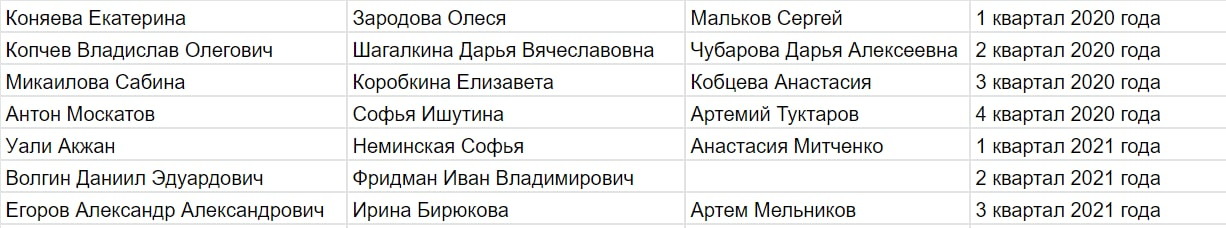

Второй квартал: 01.04–30.06.